# Comparison of GP Classification Methods with Logistic Regression Cont.

Here, we will continue the work from the previous notebook. For detailed notes, about simulations, as well data in general, refer to previous notebook.

In [3]:
%pylab inline
import time
import GPy
import numpy as np
import matplotlib;matplotlib.rcParams['figure.figsize']=(10,6)
from matplotlib import pyplot as plt
from scipy import optimize

Populating the interactive namespace from numpy and matplotlib


# Simulation 3

In this part, we will look at making the nonlinearity of the latent function more complex. For simplicity and time-reasons, we will use the data with just 100 input points.  The idea here is to further  demonstrate the flexibility of GP models, while showing the lack of flexibility of logistic regression. Of course we will also demonstrate the comparartive performance of the two different GP models.

More specifically, we consider the *sinc* function, and keep everything else the same as simulation 1. This funtion is defined as:

$$\text{sinc}(x) = \frac{\sin(\pi x)}{(\pi x)}$$

Our latent function in this case is a non-periodic function (cf. simulation 3).



## Setting Up Simulation Data

Here, we will set up our simulated data. The data is set up in the exact same way as in simulation 1, but with the complexity of the latent function increased.

In [4]:
np.random.seed(101)             #to make it reproducible

X = np.random.rand(100,1)*12    #draws from uniform distribution on [0,1) scaled by 12; data
f = 4*np.sinc(X/2)           #Appling f to X
p = np.exp(f)/(1+np.exp(f))      #Applying sigmoid function to f to return probabilities
Y = np.where(p>np.random.rand(*p.shape), 1,0)    #assign random classes
M=10
Z=np.random.rand(M,1)*12        #10 draws fron uniform distribution scaled by 12, inducing points

In [111]:
print(f"X: {X.shape}, f:{f.shape}, p: {p.shape}\nY:{Y.shape}, Z:{Z.shape}")

X: (100, 1), f:(100, 1), p: (100, 1)
Y:(100, 1), Z:(10, 1)


In [5]:
#Ordering variables

order = np.argsort(X[:,0])
X_ordered = X[order]
f_ordered = f[order]
p_ordered = p[order]

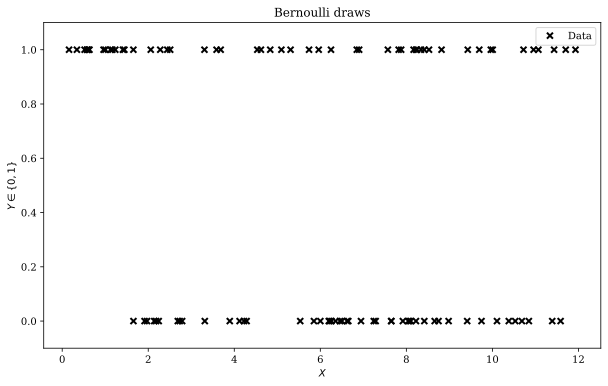

In [115]:
#Plot of data

plt.plot(X, Y, 'kx', mew=2)
plt.ylim(-0.1, 1.1)
plt.title('Bernoulli draws')
plt.xlabel('$X$')
plt.ylabel('$Y \in \{0,1\}$')
plt.legend( ["Data"], loc="best")

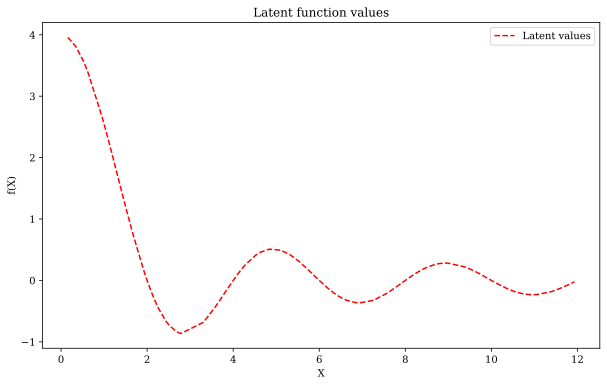

In [116]:
#Plotting latent function values

plt.plot(X_ordered, f_ordered, color="red", ls="--")
plt.title('Latent function values')
plt.xlabel('X')
plt.ylabel('f(X)')
plt.legend( ['Latent values'], loc="best")
#plt.plot(X, p, 'r.')

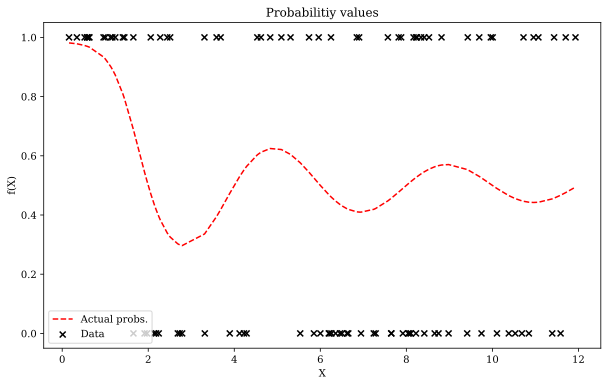

In [117]:
#Plotting actual probabilities

plt.plot(X_ordered, p_ordered, color="red", ls="--")
plt.scatter(X,Y, color="black", marker="x")
plt.title('Probabilitiy values')
plt.xlabel('X')
plt.ylabel('f(X)')
plt.legend( ['Actual probs.', "Data"], loc="best")
#plt.plot(X, p, 'r.')

## GP Variational Classification

In [118]:
#Stochastic Variational GP model, with sparse approximations 


m = GPy.core.SVGP(X, Y, kernel=GPy.kern.RBF(1)+GPy.kern.White(1), likelihood=GPy.likelihoods.Bernoulli(), Z=Z)

Text(0.5, 1.0, 'Prediction of latent probabilities - sparse model, optimized')

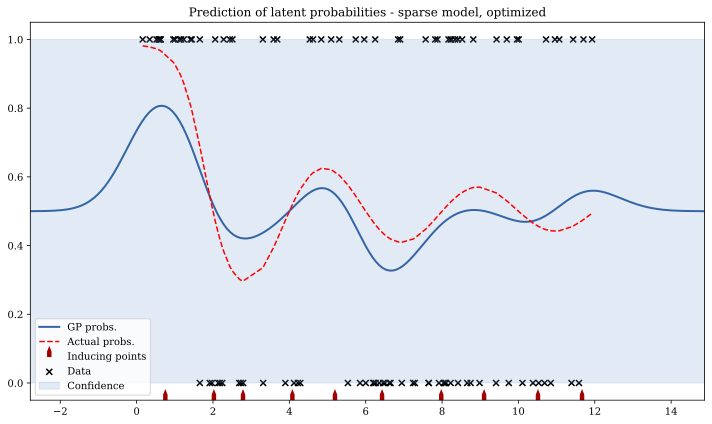

In [119]:
#Optimizing model and plotting model probabilities

t0 = time.time()
m.optimize('bfgs')
t1 = time.time()

m.plot()   #model plot of probabilities
plt.plot(X_ordered, p_ordered, color="red", ls="--")   #actual plot of probabilities
plt.legend( ['GP probs.', 'Actual probs.', "Inducing points", "Data", "Confidence"])
plt.title("Prediction of latent probabilities - sparse model, optimized")
#plt.plot(X, p, 'r.')

In [120]:
#Time taken

print(f'Time taken for sparse variational model: {t1-t0}')

Time taken for sparse variational model: 2.646960973739624


In [121]:
#Model output 

dir(m) #model attributes
m

SVGP.,value,constraints,priors
inducing inputs,"(10, 1)",,
sum.rbf.variance,0.2301411349758946,+ve,
sum.rbf.lengthscale,0.8859361222394763,+ve,
sum.white.variance,2.3711132118881882e-07,+ve,
q_u_chol,"(55, 1)",,
q_u_mean,"(10, 1)",,


In [122]:
#Full model, without sparse approximations

m_full = GPy.models.GPVariationalGaussianApproximation(X, Y, kernel=GPy.kern.RBF(1)+GPy.kern.White(1), likelihood=GPy.likelihoods.Bernoulli())

Text(0.5, 1.0, 'Prediction of latent probabilities - full model, optimized')

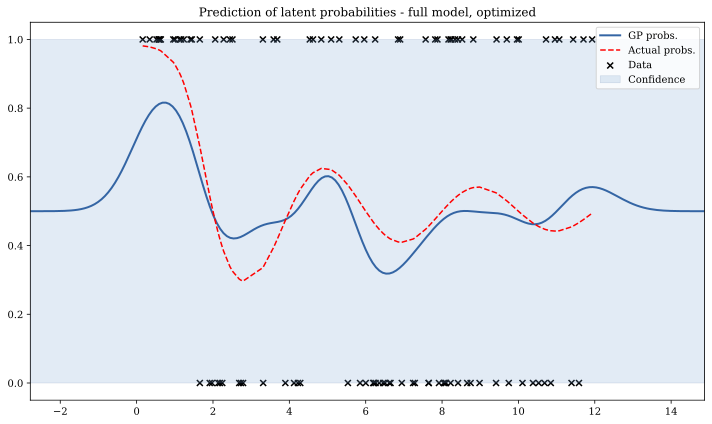

In [123]:
#Optimizing model and plotting model probabilities

t0 = time.time()
m_full.optimize()
t1 = time.time()

m_full.plot()   #full model plot of probabilities 
plt.plot(X_ordered, p_ordered, color="red", ls="--")  #actual plot of probabilities
plt.legend( ['GP probs.', 'Actual probs.', "Data", "Confidence"])
plt.title("Prediction of latent probabilities - full model, optimized")

#plt.plot(X, p, 'r.')

In [124]:
#Time taken

print(f'Time taken for full variational model: {t1-t0}')

Time taken for full variational model: 0.9119133949279785


In [125]:
#Model output

dir(m_full)  #model attributes
m_full

VarGP.,value,constraints,priors
sum.rbf.variance,0.23886066386782617,+ve,
sum.rbf.lengthscale,0.6992862917462084,+ve,
sum.white.variance,0.00020895689604667926,+ve,
alpha,"(100, 1)",,
beta,"(100,)",,


## GP Laplacian Classification

In [2]:
#PLotting specifications

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#import matplotlib;matplotlib.rcParams['text.usetex'] = True
import matplotlib;matplotlib.rcParams['font.size'] = 16
import matplotlib;matplotlib.rcParams['font.family'] = 'serif'

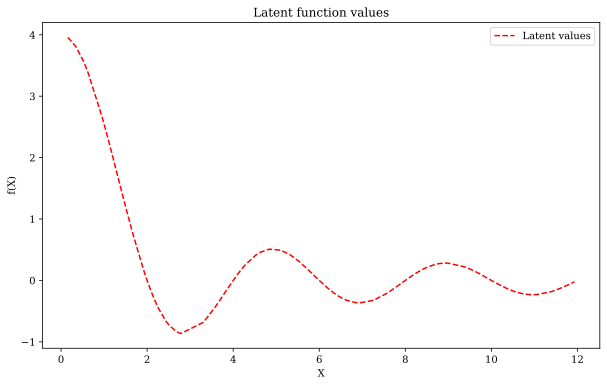

In [126]:
#Plotting latent function values again

plt.plot(X_ordered, f_ordered, color="red", ls="--")
plt.title('Latent function values')
plt.xlabel('X')
plt.ylabel('f(X)')
plt.legend( ['Latent values'], loc="best")
#plt.plot(X, p, 'r.')

In [6]:
#Obtaining probabilities for Laplacian method - uses probit link instead of logit

lik = GPy.likelihoods.Bernoulli()    #Bernoulli likelihood
p_lap = lik.gp_link.transf(f)            #Link function giving probabilities associated with f - applies probit transformation
p_lap_ordered = p_lap[order]
p.shape

(100, 1)

Text(0, 0.5, '$\\sigma(f(x))$')

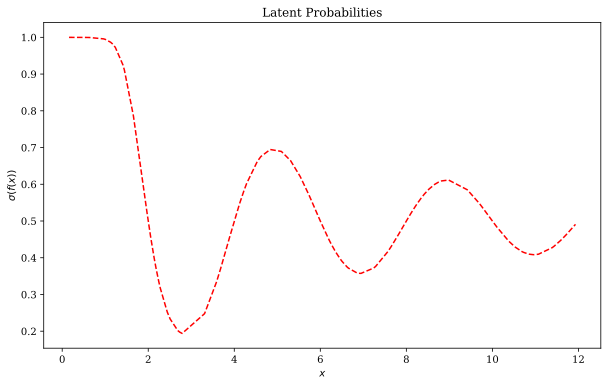

In [7]:
#Plot of latent probabilities obtained from f

plt.plot(X_ordered, p_lap_ordered, color="red", ls="--")
plt.title('Latent Probabilities')
plt.xlabel('$x$')
plt.ylabel('$\sigma(f(x))$')

In [130]:
#Creating Laplacian inference model

t0 = time.time()
kl = GPy.kern.RBF(1, variance=1., lengthscale=1)        #Kernel with specific legnthscale and variance, both set to units
laplace_inf = GPy.inference.latent_function_inference.Laplace()
m_laplace = GPy.core.GP(X=X,
                Y=Y, 
                kernel=kl, 
                inference_method=laplace_inf,
                likelihood=lik)
t1 = time.time()

In [131]:
#Time taken

print(f'Time taken for unoptimized Laplacian model: {t1-t0}')

Time taken for unoptimized Laplacian model: 0.032012224197387695


In [132]:
#Output of unoptimized model

print(m_laplace)


Name : gp
Objective : 68.67067876432873
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp.              |  value  |  constraints  |  priors
  rbf.variance     |    1.0  |      +ve      |        
  rbf.lengthscale  |    1.0  |      +ve      |        


Text(0.5, 1.0, 'Prediction of latent values - unoptimized')

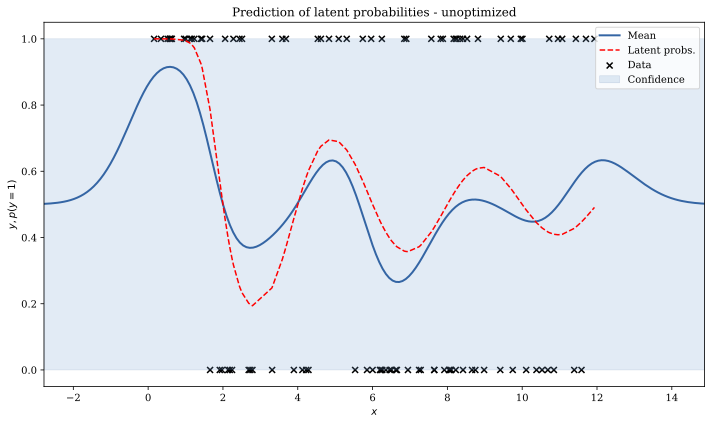

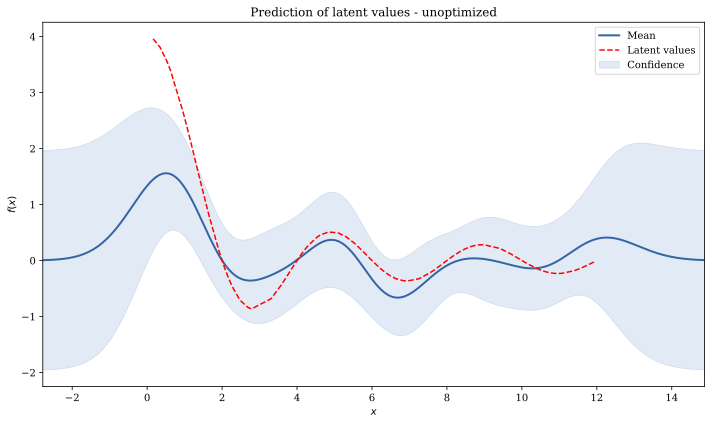

In [133]:
#Plot Laplacian inference model, unoptimized

#Plot of latent probabilities, with predictions of mean and confidence intervals

m_laplace.plot()
plt.plot(X_ordered, p_lap_ordered, color="red", ls="--")
plt.ylabel('$y, p(y=1)$')
plt.xlabel('$x$')
plt.legend( ["Mean", "Latent probs.", "Data", "Confidence"], loc="best")
plt.title("Prediction of latent probabilities - unoptimized")

m_laplace.plot_f()
plt.plot(X_ordered, f_ordered, color="red", ls="--")
plt.ylabel('$f(x)$')
plt.xlabel('$x$')
plt.legend( ["Mean", "Latent values", "Confidence"], loc="best")
plt.title("Prediction of latent values - unoptimized")

In [134]:
#Optimizing 

t0= time.time()
m_laplace.optimize('bfgs', max_iters=100)
t1 = time.time()
print(m_laplace)


Name : gp
Objective : 67.45272106770618
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp.              |               value  |  constraints  |  priors
  rbf.variance     |  0.2349884322969722  |      +ve      |        
  rbf.lengthscale  |  0.7013753624243282  |      +ve      |        


In [135]:
#Time taken

print(f'Time taken for Laplacian model: {t1-t0}')

Time taken for Laplacian model: 0.19333195686340332


Text(0.5, 1.0, 'Prediction of latent values - optimized')

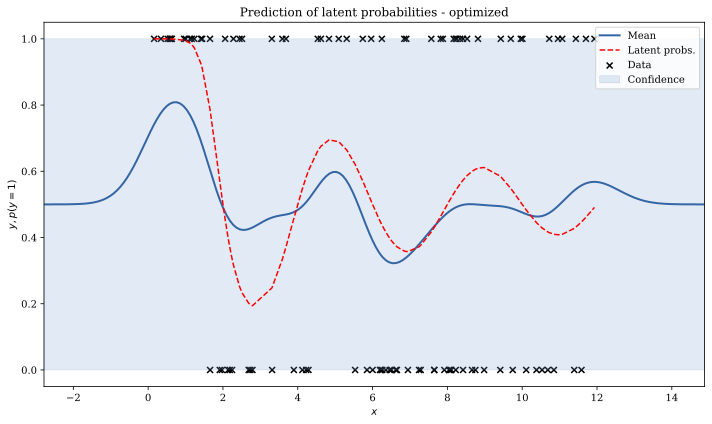

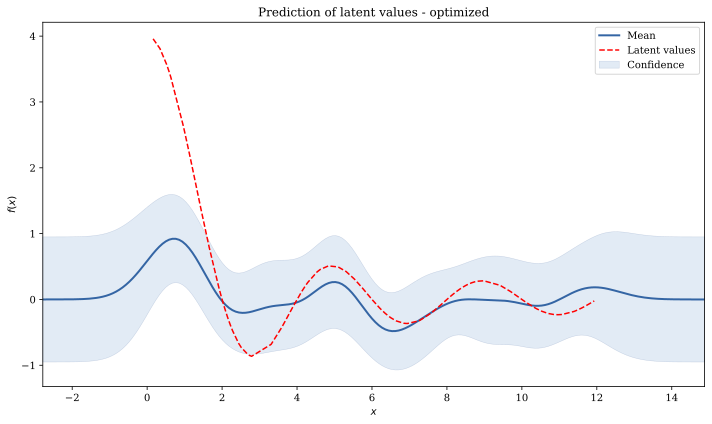

In [136]:
#Plot Laplacian inference model, optimized

#Plot of latent probabilities, with predictions of mean and confidence intervals


m_laplace.plot()
plt.plot(X_ordered, p_lap_ordered, color="red", ls="--")
plt.ylabel('$y, p(y=1)$')
plt.xlabel('$x$')
plt.legend( ["Mean", "Latent probs.", "Data", "Confidence"], loc="best")
plt.title("Prediction of latent probabilities - optimized")

m_laplace.plot_f()
plt.plot(X_ordered, f_ordered, color="red", ls="--")
plt.ylabel('$f(x)$')
plt.xlabel('$x$')
plt.legend( ["Mean", "Latent values", "Confidence"], loc="best")
plt.title("Prediction of latent values - optimized")

## Logistic Regression for Classification

In [3]:
#Importing necessary modules

import pandas as pd
from statsmodels.tools import add_constant
import statsmodels.api as sm
from scipy.special import expit, logit

In [137]:
#Fitting logistic regression model with logit link, including intercept term

X_design = add_constant(X)
t0 = time.time()
model = sm.Logit(Y, X_design).fit()
t1 = time.time()

Optimization terminated successfully.
         Current function value: 0.676038
         Iterations 4


In [138]:
#Time taken

print(f'Time taken for logistic regression model: {t1-t0}')

Time taken for logistic regression model: 0.007996797561645508


In [139]:
#Model summary

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                            1
Date:                Mon, 14 Dec 2020   Pseudo R-squ.:                 0.02356
Time:                        10:48:13   Log-Likelihood:                -67.604
converged:                       True   LL-Null:                       -69.235
Covariance Type:            nonrobust   LLR p-value:                   0.07091
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7260      0.418      1.737      0.082      -0.093       1.545
x1            -0.1083      0.061     -1.779      0.075      -0.228       0.011
==============================================================================
"""

In [140]:
#Making predictions of latent probabilities

predictions = model.predict(X_design).reshape(100,1)
predictions.shape

(100, 1)

In [141]:
#Finding 95% confidence intervals for predicted probabilities

se= np.sqrt(np.array([xx@model.cov_params()@xx for xx in X_design]))   #standards errors of predictions
se = se.reshape(100,1)                                                 #reshaping se
conf_lower_prob = expit(logit(predictions) - 1.96*se)
conf_upper_prob = expit(logit(predictions) + 1.96*se)

Text(0.5, 1.0, 'Prediction of latent probabilities - optimized')

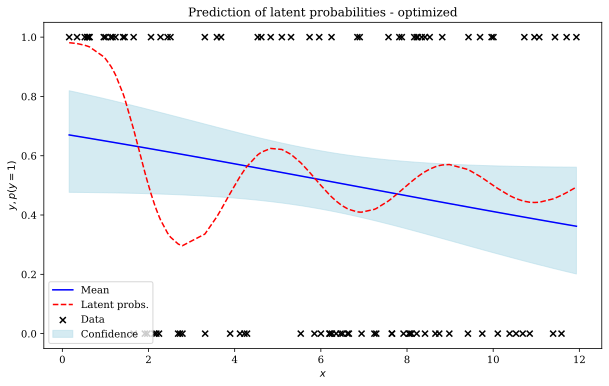

In [142]:
#Plotting mean of predictions with 95% confidence interval

#Ordering for plotting

ordered_pred = predictions[order]                      #ordering probability predictions
ordered_conf_lower_prob = conf_lower_prob[order]               #Order confidence intervals for plotting
ordered_conf_upper_prob = conf_upper_prob[order]     

plt.plot(X_ordered, ordered_pred, color="blue")
plt.scatter(X, Y, marker="x", color="black")
plt.plot(X_ordered, p_ordered, color="red", ls="--")
plt.fill_between(X_ordered.reshape(100), ordered_pred.reshape(100), 
                 ordered_conf_upper_prob.reshape(100), color='lightblue', alpha=.5)
plt.fill_between(X_ordered.reshape(100), ordered_conf_lower_prob.reshape(100), 
                 ordered_pred.reshape(100), color='lightblue', alpha=.5)
plt.ylabel('$y, p(y=1)$')
plt.xlabel('$x$')
plt.legend( ["Mean", "Latent probs.", "Data", "Confidence"], loc="best")
plt.title("Prediction of latent probabilities - optimized")


#Upper confidence bound and lower confidence bound

#plt.plot(X_ordered, ordered_conf_lower_prob, color="violet")
#plt.plot(X_ordered, ordered_conf_upper_prob, color="violet")

Text(0.5, 1.0, 'Prediction of latent values - optimized')

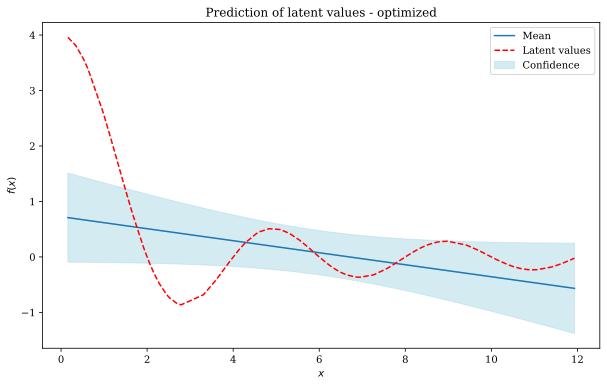

In [143]:
#Prediction of latent values

ordered_values_pred = logit(ordered_pred)   #ordered value predictions obtained by  applying logit to probability predictions

plt.plot(X_ordered, ordered_values_pred)
plt.plot(X_ordered, f_ordered, color="red", ls="--")
plt.fill_between(X_ordered.reshape(100), ordered_values_pred.reshape(100), 
                 logit(ordered_conf_upper_prob).reshape(100), color='lightblue', alpha=.5)
plt.fill_between(X_ordered.reshape(100), logit(ordered_conf_lower_prob).reshape(100), 
                 ordered_values_pred.reshape(100), color='lightblue', alpha=.5)
plt.ylabel('$f(x)$')
plt.xlabel('$x$')
plt.legend( ["Mean", "Latent values", "Confidence"], loc="best")
plt.title("Prediction of latent values - optimized")

## Comparing Classification Methods

Here we will compare the classification methods based on their fit to the training data. For the future we may consider subsetting our data into a train-validation-test split.

In [144]:
#Prediction from sparse variational model
#Classification bsaed on threshold of 0.5

predict_sparse_var = m.predict(X)[0]
classification_sparse_var = np.where(predict_sparse_var >= 0.5, 1, 0)
CRR_sparse_var = np.where(classification_sparse_var == Y)[0].size/Y.size    #corect classification rate

In [145]:
#Prediction from full variational model
#Classification bsaed on threshold of 0.5

predict_full_var = m_full.predict(X)[0]
classification_full_var = np.where(predict_full_var >= 0.5, 1, 0)
CRR_full_var = np.where(classification_full_var == Y)[0].size/Y.size    #corect classification rate

In [146]:
CRR_full_var, CRR_sparse_var

(0.64, 0.64)

In [147]:
#Prediction from laplacian model
#Classification bsaed on threshold of 0.5

predict_laplace = m_laplace.predict(X)[0]
classification_laplace = np.where(predict_laplace >= 0.5, 1, 0)
CRR_laplace = np.where(classification_laplace == Y)[0].size/Y.size    #corect classification rate

In [148]:
CRR_laplace

0.64

In [149]:
#Prediction from logistic regression model
#Classification bsaed on threshold of 0.5

classification_logistic = np.where(predictions >= 0.5, 1, 0)
CRR_logistic = np.where(classification_logistic == Y)[0].size/Y.size    #corect classification rate

In [153]:
CRR_logistic

0.54

### Summary:

Here, logistic regressions performs the worst, whilst the Laplace and variational methods perform the best - in terms of CRR on the trianing set. The Laplace, full and sparse variational models perform the same CRRs.

By inspection, the variational models perform the best approximations for the latent function, followed the the Laplace model then the logistic regression model.

Computation wise, logistic regression was the best, followed by the Laplace model, then by the full variational model then the sparse variational model. This is likely due to the relatively low input size in comparison to the number of parameters being optimized.


# Simulation 4

In this part, we will look at making the nonlinearity of the latent function even more complex (analogous to noise). For simplicity and time-reasons, we will use the data with just 100 input points. The idea here is to demonstrate that GP models, while flexible, still have weaknesses like other parametric/non-parametric models.

More specifically, we insert a polynomial term into the argument of the cosine, and keep everything else the same as simulation 1.

## Setting Up Simulation Data

Here, we will set up our simulated data. The data is set up in the exact same way as in simulation 1, but we increase the complexity of the latent function.

In [8]:
np.random.seed(101)             #to make it reproducible

X = np.random.rand(100,1)*12    #draws from uniform distribution on [0,1) scaled by 12; data
f = np.cos(np.power(X,3)/3)*3.8             #Appling f to X
p =np.exp(f)/(1+np.exp(f))      #Applying sigmoid function to f to return probabilities
Y = np.where(p>np.random.rand(*p.shape), 1,0)    #assign random classes
M=10
Z=np.random.rand(M,1)*12        #10 draws fron uniform distribution scaled by 12, inducing points

In [156]:
print(f"X: {X.shape}, f:{f.shape}, p: {p.shape}\nY:{Y.shape}, Z:{Z.shape}")

X: (100, 1), f:(100, 1), p: (100, 1)
Y:(100, 1), Z:(10, 1)


In [9]:
#Ordering variables

order = np.argsort(X[:,0])
X_ordered = X[order]
f_ordered = f[order]
p_ordered = p[order]

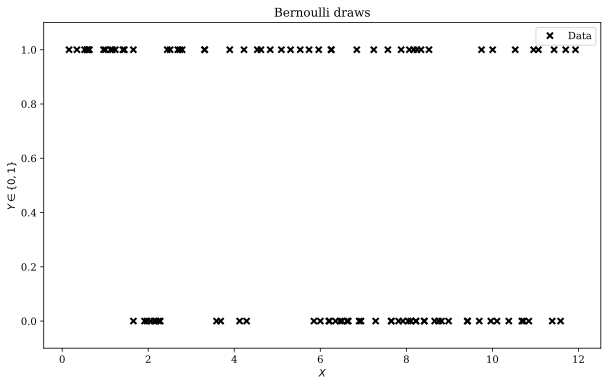

In [158]:
#Plot of data

plt.plot(X, Y, 'kx', mew=2)
plt.ylim(-0.1, 1.1)
plt.title('Bernoulli draws')
plt.xlabel('$X$')
plt.ylabel('$Y \in \{0,1\}$')
plt.legend( ["Data"], loc="best")

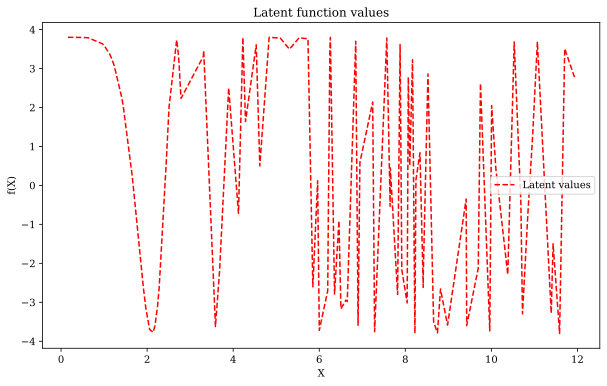

In [159]:
#Plotting latent function values

plt.plot(X_ordered, f_ordered, color="red", ls="--")
plt.title('Latent function values')
plt.xlabel('X')
plt.ylabel('f(X)')
plt.legend( ['Latent values'], loc="best")
#plt.plot(X, p, 'r.')

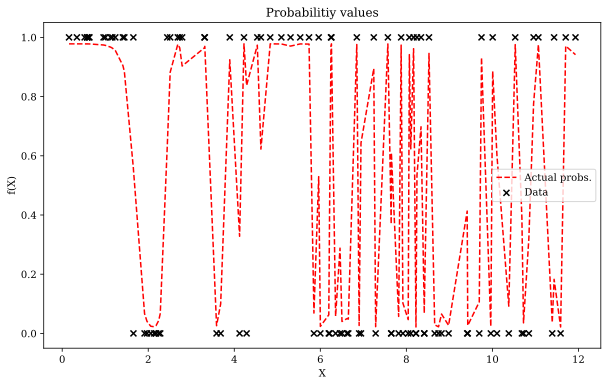

In [160]:
#Plotting actual probabilities

plt.plot(X_ordered, p_ordered, color="red", ls="--")
plt.scatter(X,Y, color="black", marker="x")
plt.title('Probabilitiy values')
plt.xlabel('X')
plt.ylabel('f(X)')
plt.legend( ['Actual probs.', "Data"], loc="best")
#plt.plot(X, p, 'r.')

## GP Variational Classification

In [161]:
#Stochastic Variational GP model, with sparse approximations 


m = GPy.core.SVGP(X, Y, kernel=GPy.kern.RBF(1)+GPy.kern.White(1), likelihood=GPy.likelihoods.Bernoulli(), Z=Z)

Text(0.5, 1.0, 'Prediction of latent probabilities - sparse model, optimized')

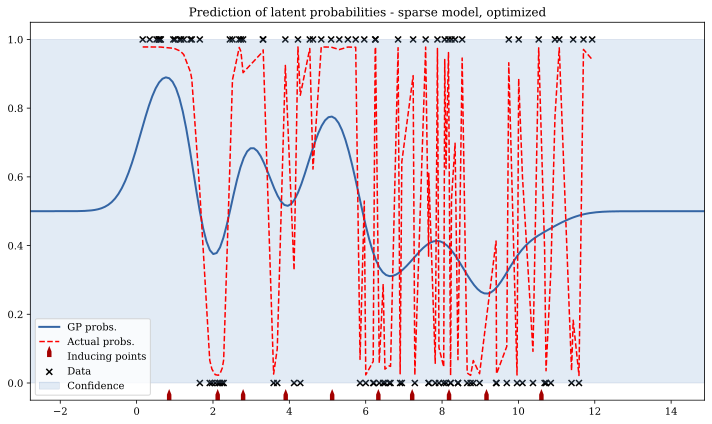

In [162]:
#Optimizing model and plotting model probabilities

t0 = time.time()
m.optimize('bfgs')
t1 = time.time()

m.plot()   #model plot of probabilities
plt.plot(X_ordered, p_ordered, color="red", ls="--")   #actual plot of probabilities
plt.legend( ['GP probs.', 'Actual probs.', "Inducing points", "Data", "Confidence"])
plt.title("Prediction of latent probabilities - sparse model, optimized")
#plt.plot(X, p, 'r.')

In [163]:
#Time taken

print(f'Time taken for sparse variational model: {t1-t0}')

Time taken for sparse variational model: 1.5561654567718506


In [164]:
#Model output 

dir(m) #model attributes
m

SVGP.,value,constraints,priors
inducing inputs,"(10, 1)",,
sum.rbf.variance,0.42800818632994325,+ve,
sum.rbf.lengthscale,0.6255061519367477,+ve,
sum.white.variance,3.5940135107232737e-09,+ve,
q_u_chol,"(55, 1)",,
q_u_mean,"(10, 1)",,


In [165]:
#Full model, without sparse approximations

m_full = GPy.models.GPVariationalGaussianApproximation(X, Y, kernel=GPy.kern.RBF(1)+GPy.kern.White(1), likelihood=GPy.likelihoods.Bernoulli())

Text(0.5, 1.0, 'Prediction of latent probabilities - full model, optimized')

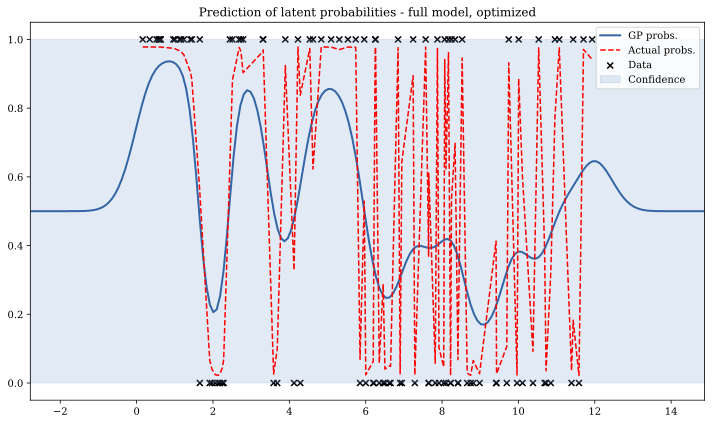

In [166]:
#Optimizing model and plotting model probabilities

t0 = time.time()
m_full.optimize()
t1 = time.time()

m_full.plot()   #full model plot of probabilities 
plt.plot(X_ordered, p_ordered, color="red", ls="--")  #actual plot of probabilities
plt.legend( ['GP probs.', 'Actual probs.', "Data", "Confidence"])
plt.title("Prediction of latent probabilities - full model, optimized")

#plt.plot(X, p, 'r.')

In [167]:
#Time taken

print(f'Time taken for full variational model: {t1-t0}')

Time taken for full variational model: 1.2078876495361328


In [168]:
#Model output

dir(m_full)  #model attributes
m_full

VarGP.,value,constraints,priors
sum.rbf.variance,0.9624877336977802,+ve,
sum.rbf.lengthscale,0.4809251868795689,+ve,
sum.white.variance,0.0013106377717650775,+ve,
alpha,"(100, 1)",,
beta,"(100,)",,


## GP Laplacian Classification

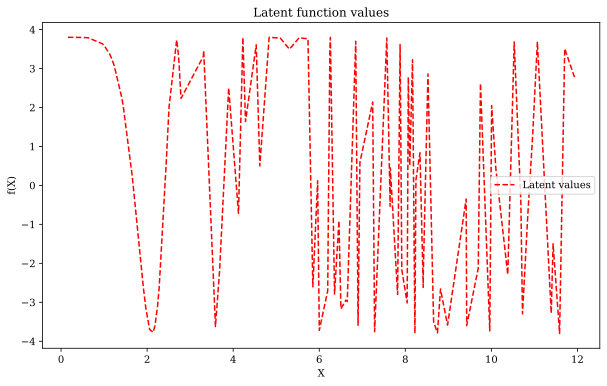

In [10]:
#Plotting latent function values again

plt.plot(X_ordered, f_ordered, color="red", ls="--")
plt.title('Latent function values')
plt.xlabel('X')
plt.ylabel('f(X)')
plt.legend( ['Latent values'], loc="best")
#plt.plot(X, p, 'r.')

In [11]:
#Obtaining probabilities for Laplacian method - uses probit link instead of logit

lik = GPy.likelihoods.Bernoulli()    #Bernoulli likelihood
p_lap = lik.gp_link.transf(f)            #Link function giving probabilities associated with f - applies probit transformation
p_lap_ordered = p_lap[order]
p.shape

(100, 1)

Text(0, 0.5, '$\\sigma(f(x))$')

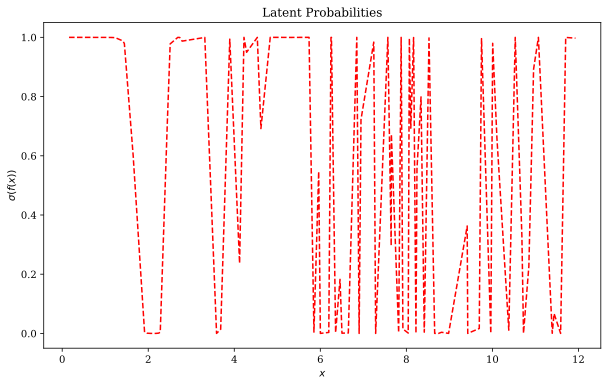

In [12]:
#Plot of latent probabilities obtained from f

plt.plot(X_ordered, p_lap_ordered, color="red", ls="--")
plt.title('Latent Probabilities')
plt.xlabel('$x$')
plt.ylabel('$\sigma(f(x))$')

In [173]:
#Creating Laplacian inference model

t0 = time.time()
kl = GPy.kern.RBF(1, variance=1., lengthscale=1)        #Kernel with specific legnthscale and variance, both set to units
laplace_inf = GPy.inference.latent_function_inference.Laplace()
m_laplace = GPy.core.GP(X=X,
                Y=Y, 
                kernel=kl, 
                inference_method=laplace_inf,
                likelihood=lik)
t1 = time.time()

In [174]:
#Time taken

print(f'Time taken for unoptimized Laplacian model: {t1-t0}')

Time taken for unoptimized Laplacian model: 0.0399930477142334


In [175]:
#Output of unoptimized model

print(m_laplace)


Name : gp
Objective : 66.2166945057945
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp.              |  value  |  constraints  |  priors
  rbf.variance     |    1.0  |      +ve      |        
  rbf.lengthscale  |    1.0  |      +ve      |        


Text(0.5, 1.0, 'Prediction of latent values - unoptimized')

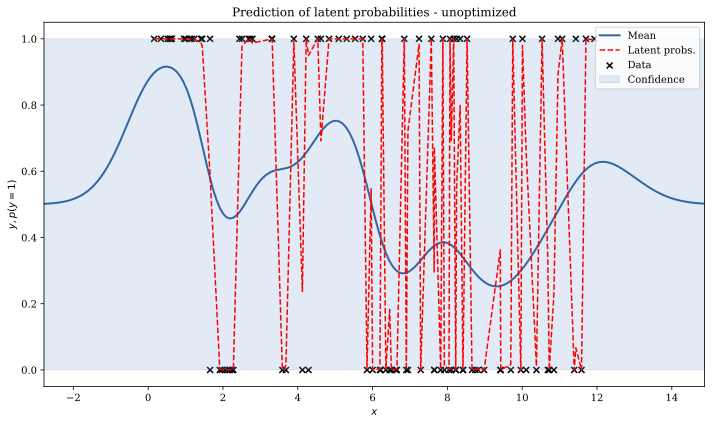

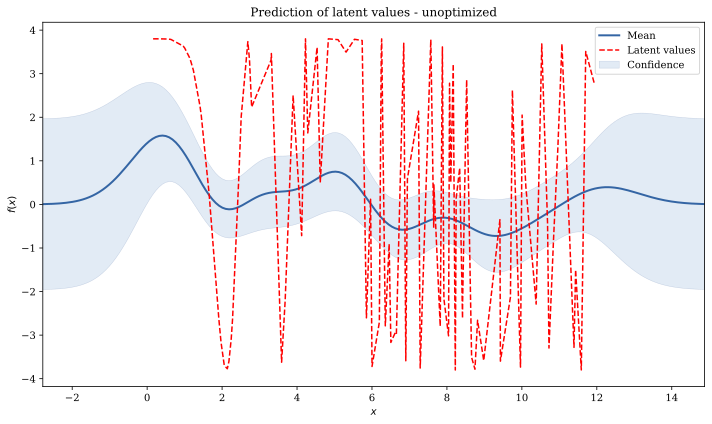

In [176]:
#Plot Laplacian inference model, unoptimized

#Plot of latent probabilities, with predictions of mean and confidence intervals

m_laplace.plot()
plt.plot(X_ordered, p_lap_ordered, color="red", ls="--")
plt.ylabel('$y, p(y=1)$')
plt.xlabel('$x$')
plt.legend( ["Mean", "Latent probs.", "Data", "Confidence"], loc="best")
plt.title("Prediction of latent probabilities - unoptimized")

m_laplace.plot_f()
plt.plot(X_ordered, f_ordered, color="red", ls="--")
plt.ylabel('$f(x)$')
plt.xlabel('$x$')
plt.legend( ["Mean", "Latent values", "Confidence"], loc="best")
plt.title("Prediction of latent values - unoptimized")

In [177]:
#Optimizing 

t0= time.time()
m_laplace.optimize('bfgs', max_iters=100)
t1 = time.time()
print(m_laplace)


Name : gp
Objective : 63.540970270101326
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp.              |                value  |  constraints  |  priors
  rbf.variance     |   0.8966134082287623  |      +ve      |        
  rbf.lengthscale  |  0.47767476965099365  |      +ve      |        


In [178]:
#Time taken

print(f'Time taken for Laplacian model: {t1-t0}')

Time taken for Laplacian model: 0.2136850357055664


Text(0.5, 1.0, 'Prediction of latent values - optimized')

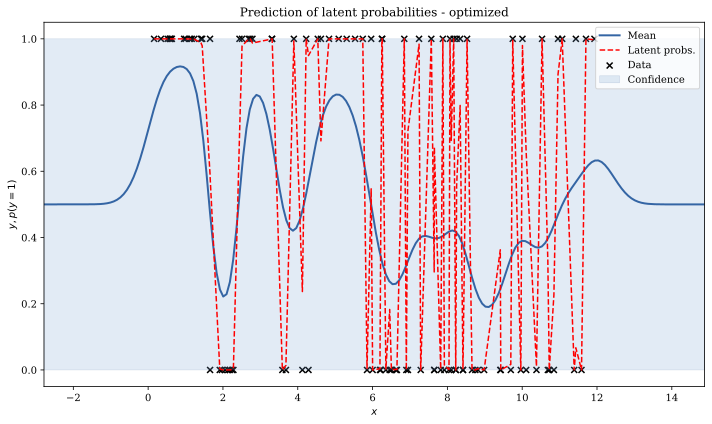

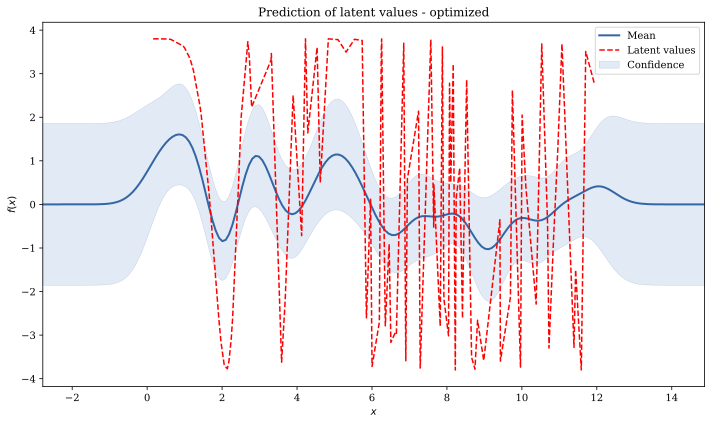

In [179]:
#Plot Laplacian inference model, optimized

#Plot of latent probabilities, with predictions of mean and confidence intervals


m_laplace.plot()
plt.plot(X_ordered, p_lap_ordered, color="red", ls="--")
plt.ylabel('$y, p(y=1)$')
plt.xlabel('$x$')
plt.legend( ["Mean", "Latent probs.", "Data", "Confidence"], loc="best")
plt.title("Prediction of latent probabilities - optimized")

m_laplace.plot_f()
plt.plot(X_ordered, f_ordered, color="red", ls="--")
plt.ylabel('$f(x)$')
plt.xlabel('$x$')
plt.legend( ["Mean", "Latent values", "Confidence"], loc="best")
plt.title("Prediction of latent values - optimized")

## Logistic Regression for Classification

In [180]:
#Fitting logistic regression model with logit link, including intercept term

X_design = add_constant(X)
t0 = time.time()
model = sm.Logit(Y, X_design).fit()
t1 = time.time()

Optimization terminated successfully.
         Current function value: 0.649900
         Iterations 5


In [181]:
#Time taken

print(f'Time taken for logistic regression model: {t1-t0}')

Time taken for logistic regression model: 0.00799870491027832


In [182]:
#Model summary

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                            1
Date:                Mon, 14 Dec 2020   Pseudo R-squ.:                 0.06212
Time:                        13:42:37   Log-Likelihood:                -64.990
converged:                       True   LL-Null:                       -69.295
Covariance Type:            nonrobust   LLR p-value:                  0.003344
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1161      0.438      2.551      0.011       0.259       1.974
x1            -0.1803      0.064     -2.817      0.005      -0.306      -0.055
==============================================================================
"""

In [183]:
#Making predictions of latent probabilities

predictions = model.predict(X_design).reshape(100,1)
predictions.shape

(100, 1)

In [184]:
#Finding 95% confidence intervals for predicted probabilities

se= np.sqrt(np.array([xx@model.cov_params()@xx for xx in X_design]))   #standards errors of predictions
se = se.reshape(100,1)                                                 #reshaping se
conf_lower_prob = expit(logit(predictions) - 1.96*se)
conf_upper_prob = expit(logit(predictions) + 1.96*se)

Text(0.5, 1.0, 'Prediction of latent probabilities - optimized')

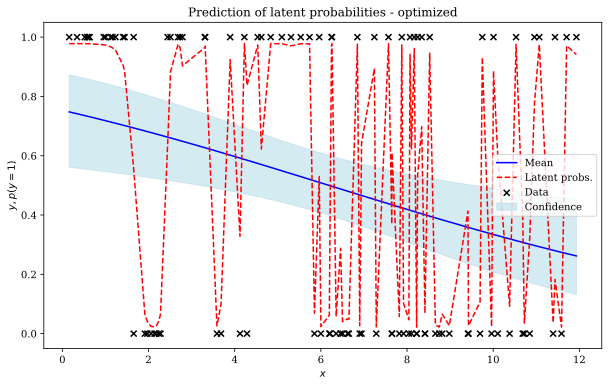

In [185]:
#Plotting mean of predictions with 95% confidence interval

#Ordering for plotting

ordered_pred = predictions[order]                      #ordering probability predictions
ordered_conf_lower_prob = conf_lower_prob[order]               #Order confidence intervals for plotting
ordered_conf_upper_prob = conf_upper_prob[order]     

plt.plot(X_ordered, ordered_pred, color="blue")
plt.scatter(X, Y, marker="x", color="black")
plt.plot(X_ordered, p_ordered, color="red", ls="--")
plt.fill_between(X_ordered.reshape(100), ordered_pred.reshape(100), 
                 ordered_conf_upper_prob.reshape(100), color='lightblue', alpha=.5)
plt.fill_between(X_ordered.reshape(100), ordered_conf_lower_prob.reshape(100), 
                 ordered_pred.reshape(100), color='lightblue', alpha=.5)
plt.ylabel('$y, p(y=1)$')
plt.xlabel('$x$')
plt.legend( ["Mean", "Latent probs.", "Data", "Confidence"], loc="best")
plt.title("Prediction of latent probabilities - optimized")


#Upper confidence bound and lower confidence bound

#plt.plot(X_ordered, ordered_conf_lower_prob, color="violet")
#plt.plot(X_ordered, ordered_conf_upper_prob, color="violet")

Text(0.5, 1.0, 'Prediction of latent values - optimized')

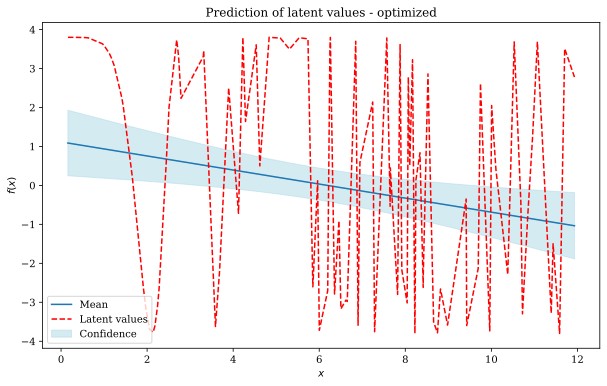

In [186]:
#Prediction of latent values

ordered_values_pred = logit(ordered_pred)   #ordered value predictions obtained by  applying logit to probability predictions

plt.plot(X_ordered, ordered_values_pred)
plt.plot(X_ordered, f_ordered, color="red", ls="--")
plt.fill_between(X_ordered.reshape(100), ordered_values_pred.reshape(100), 
                 logit(ordered_conf_upper_prob).reshape(100), color='lightblue', alpha=.5)
plt.fill_between(X_ordered.reshape(100), logit(ordered_conf_lower_prob).reshape(100), 
                 ordered_values_pred.reshape(100), color='lightblue', alpha=.5)
plt.ylabel('$f(x)$')
plt.xlabel('$x$')
plt.legend( ["Mean", "Latent values", "Confidence"], loc="best")
plt.title("Prediction of latent values - optimized")

## Comparing Classification Methods

Here we will compare the classification methods based on their fit to the training data. For the future we may consider subsetting our data into a train-validation-test split.

In [187]:
#Prediction from sparse variational model
#Classification bsaed on threshold of 0.5

predict_sparse_var = m.predict(X)[0]
classification_sparse_var = np.where(predict_sparse_var >= 0.5, 1, 0)
CRR_sparse_var = np.where(classification_sparse_var == Y)[0].size/Y.size    #corect classification rate

In [188]:
#Prediction from full variational model
#Classification bsaed on threshold of 0.5

predict_full_var = m_full.predict(X)[0]
classification_full_var = np.where(predict_full_var >= 0.5, 1, 0)
CRR_full_var = np.where(classification_full_var == Y)[0].size/Y.size    #corect classification rate

In [189]:
CRR_full_var, CRR_sparse_var

(0.77, 0.73)

In [190]:
#Prediction from laplacian model
#Classification bsaed on threshold of 0.5

predict_laplace = m_laplace.predict(X)[0]
classification_laplace = np.where(predict_laplace >= 0.5, 1, 0)
CRR_laplace = np.where(classification_laplace == Y)[0].size/Y.size    #corect classification rate

In [191]:
CRR_laplace

0.76

In [192]:
#Prediction from logistic regression model
#Classification bsaed on threshold of 0.5

classification_logistic = np.where(predictions >= 0.5, 1, 0)
CRR_logistic = np.where(classification_logistic == Y)[0].size/Y.size    #corect classification rate

In [193]:
CRR_logistic

0.67

### Summary:

Here, logistic regressions performs the worst, whilst the full variational method performs the best - in terms of CRR on the training set. The Laplace model is the second best performing, followed by the sparse variational method.

By inspection, none of the model capture the noise-like input of the latent function/probabilitiy values. Although, the full variational model arguably provides the best approximation, followed by the Laplacian then the sparse model. Of course logistic regression is not able to capture any of the curavture and thus provides the poorest approximation.

Computation wise, logistic regression was the best, followed by the Laplace model, then by the full variational model then the sparse variational model. This is likely due to the relatively low input size in comparison to the number of parameters being optimized.
